In [1]:
# %matplotlib inline
from klearn_tcyclone.climada.tc_tracks import TCTracks
import numpy as np
from itertools import product
import os

import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks

from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from kooplearn.models import Kernel, NystroemKernel
from klearn_tcyclone.kooplearn.models.nystroem import NystroemKernelCustom

from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.models_utils import predict_time_series

from kooplearn.utils import topk

from klearn_tcyclone.climada.tc_tracks_tools import BASINS_ALL, BASINS_SELECTION

from klearn_tcyclone.utils import check_time_steps_TCTracks
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling, slide_by_scaling, get_top_k_ev_below_zero, train_model
from klearn_tcyclone.climada.utils import get_TCTrack_dict

from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling

from klearn_tcyclone.training_utils.training_utils import (
    extend_by_default_flag_values,
)

from itertools import product
import umap
import pandas as pd

from klearn_tcyclone.data_utils import load_model_results, load_model

from klearn_tcyclone.kooplearn.spectral_analysis import get_df_evecs

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from klearn_tcyclone.kooplearn.spectral_analysis import get_top_k_ev_and_indices_below_zero

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from kooplearn.data import TensorContextDataset
from klearn_tcyclone.data_utils import standardized_context_dataset_from_TCTracks

from random import sample

In [3]:
print(f"Basins are given by {BASINS_ALL}.")

Basins are given by ['EP', 'NA', 'NI', 'SI', 'SP', 'WP', 'SA'].


In [5]:
BASINS_SELECTION

current_file_dir_path = os.getcwd()
path_training_results = os.path.join(
    current_file_dir_path,
    "../train_models/",
    "training_results",
)

model_str = "Nystroem_RRR"

flag_params = {
    "koopman_kernel_num_train_stops": 10,
    "year_range": [1980, 2021],
    "model": model_str,
    "koopman_kernel_length_scale": 10.0,
    "koopman_kernel_rank": 50,
    "koopman_kernel_num_centers": 800,
    "context_length": 32,
    "koopman_kernel_reduced_rank": False,
    "time_step_h": 1.0,
}
flag_params = extend_by_default_flag_values(flag_params)


model_config = {
    "length_scale": 10.0,
    "reduced_rank": False,
    "rank": 50,
    "num_centers": 600,
    "tikhonov_reg": 1e-8,
    "svd_solver": "arnoldi",
    "rng_seed": 42,
}

top_k = 10
# top_k = 42
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    "radius_max_wind",
    "radius_oci",
    "central_pressure",
    "environmental_pressure",
]

time_lag = 1
slide_by = 1

In [5]:
basins = BASINS_SELECTION

In [6]:
# basins = BASINS_SELECTION[:2]

In [6]:
# Datasets
tc_tracks_dict = get_TCTrack_dict(
    basins=basins,
    time_step_h=flag_params["time_step_h"],
    year_range=flag_params["year_range"],
)


for basin in basins:
    tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks_dict[basin].data, test_size=0.1, random_state=flag_params["seed"])
    tc_tracks_dict[basin] = {
        "train": tc_tracks_train,
        "test": tc_tracks_test,
    }




contexts = {}
for basin in basins:
    scaler = LinearScaler()
    tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
        tc_tracks_dict[basin]["train"],
        feature_list=feature_list,
        scaler=scaler,
        context_length=flag_params["context_length"],
        time_lag=time_lag,
        fit=True,
        periodic_shift=True,
        basin=basin,
    )
    tensor_context_test_standardized = standardized_context_dataset_from_TCTracks(
        tc_tracks_dict[basin]["test"],
        feature_list=feature_list,
        scaler=scaler,
        context_length=flag_params["context_length"],
        time_lag=time_lag,
        fit=False,
        periodic_shift=True,
        basin=basin,
    )

    contexts[basin] = {
        "train": tensor_context_train_standardized,
        "test": tensor_context_test_standardized,
    }
    

2024-12-30 20:28:28,438 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-12-30 20:29:34,677 - climada.hazard.tc_tracks - WARNING - 232 storm events are discarded because no valid wind/pressure values have been found: 1980094N06181, 1980161N09249, 1980169N12250, 1980177N13259, 1980183N13250, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:
d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:1511: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_one_interp_data" failed type inference due to: non-precise type pyobject
During: typing of argument at d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py (1545)

File "..\.venv\Lib\site-packages\climada\hazard\tc_tracks.py", line 1545:
    def _one_interp_data(track, time_step_h, land_geom=None):
       

2024-12-30 20:29:57,401 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-12-30 20:30:39,200 - climada.hazard.tc_tracks - WARNING - 57 storm events are discarded because no valid wind/pressure values have been found: 1980199N31284, 1980200N25270, 1980204N23287, 1980226N15339, 1980238N16328, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


2024-12-30 20:30:58,792 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-12-30 20:31:54,052 - climada.hazard.tc_tracks - WARNING - 134 storm events are discarded because no valid wind/pressure values have been found: 1980015S18060, 1980032S14071, 1980056S15059, 1980068S13068, 1980075S11072, ...
2024-12-30 20:31:54,061 - climada.hazard.tc_tracks - WARNING - 9 storm events are discarded because only one valid timestep has been found: 1980002S15081, 1980005S11059, 1980009S14066, 1980010S20043, 1980010S22048, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


2024-12-30 20:32:16,879 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-12-30 20:32:49,359 - climada.hazard.tc_tracks - WARNING - 71 storm events are discarded because no valid wind/pressure values have been found: 1980085S11135, 1981022S13155, 1983027S21224, 1983082S15216, 1983347S16154, ...
2024-12-30 20:32:49,366 - climada.hazard.tc_tracks - WARNING - 1 storm events are discarded because only one valid timestep has been found: 1992358S07161.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


2024-12-30 20:33:04,264 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-12-30 20:34:29,738 - climada.hazard.tc_tracks - WARNING - 360 storm events are discarded because no valid wind/pressure values have been found: 1980076N06148, 1980087N13117, 1980181N10130, 1980197N15133, 1980225N11145, ...
2024-12-30 20:34:29,749 - climada.hazard.tc_tracks - WARNING - 2 storm events are discarded because only one valid timestep has been found: 1996318N33146, 2004327N16125.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Data entry 3 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 36 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 103 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 163 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 200 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 256 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 372 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 397 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 443 has been removed since it is shorter than th

## Plot eigenfunctions along trajectories

<GeoAxes: >

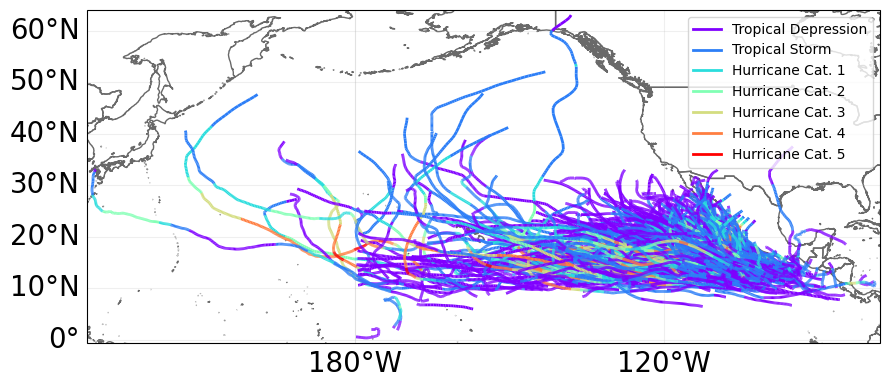

In [ ]:
tc_tracks_dict["EP"].plot()

In [111]:
basin = "EP"

In [112]:
# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
kernel = RBF(length_scale=model_config["length_scale"])
nys_rrr = NystroemKernelCustom(
    kernel=kernel,
    reduced_rank=model_config["reduced_rank"],
    svd_solver=model_config["svd_solver"],
    tikhonov_reg=model_config["tikhonov_reg"],
    rank=model_config["rank"],
    num_centers=model_config["num_centers"],
    rng_seed=model_config["rng_seed"],
)
nys_rrr = nys_rrr.fit(contexts[basin]["train"], slide_by=slide_by)

In [113]:
test_dataset = contexts[basin]["train"]

In [114]:
evals, evec_right = nys_rrr.eig(eval_right_on=test_dataset)

In [115]:
test_dataset.shape

(72794, 32, 7)

In [116]:
evec_right.shape

(72794, 50)

In [117]:
# evals_k = evals
# evec_right_k = evec_right

indices_k, evals_k = get_top_k_ev_and_indices_below_zero(evals, top_k)
print(evals_k)

# top_evals = topk(np.abs(evals), top_k)
# indices_k = top_evals.indices
# evals_k = evals[indices_k]
# print(evals_k)

evec_right_k = evec_right[:, indices_k]

[0.99993462+0.00304603j 0.99993462-0.00304603j 0.99865761+0.00627812j
 0.99865761-0.00627812j 0.99820358+0.02708755j 0.99820358-0.02708755j
 0.99782464+0.00030959j 0.99782464-0.00030959j 0.99765184+0.01776714j
 0.99765184-0.01776714j]


In [118]:
evec_idx = list(range(top_k))
# evec_idx = list(range(0, 50, 4))

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\matplotlib\axes\_axes.py:4590: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


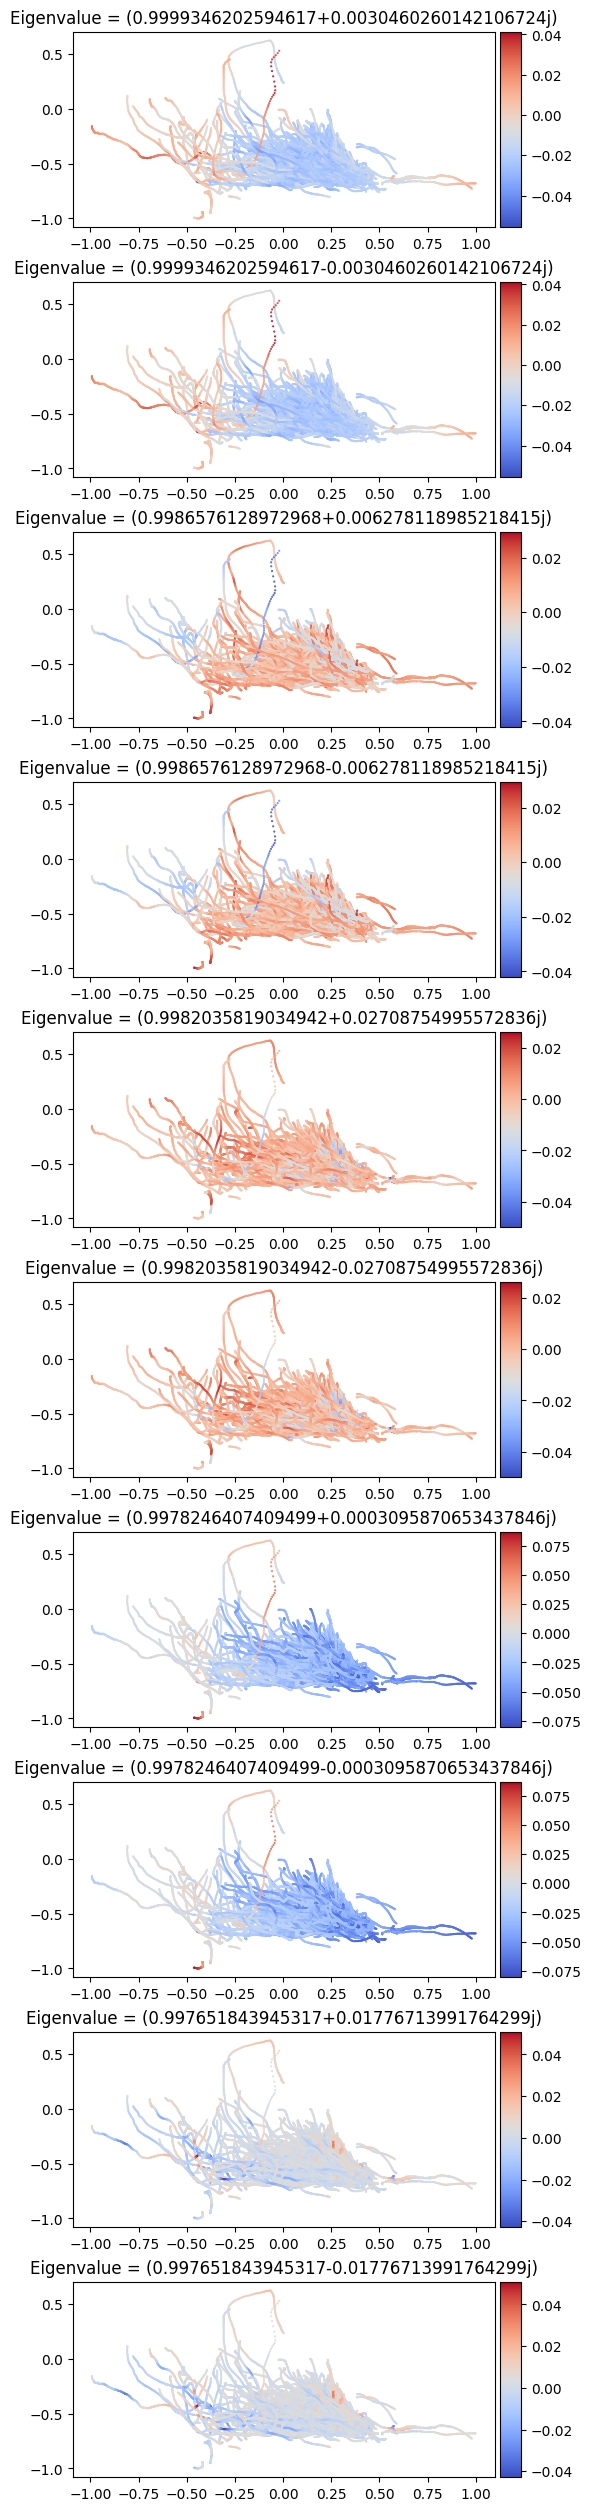

In [119]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(len(evec_idx), 1, constrained_layout=True)
fig.set_size_inches(5, 25)

idx = -1
cmap = plt.cm.coolwarm

for i, e_idx in enumerate(evec_idx):
    im = ax[i].scatter(test_dataset.data[:idx, 0, 0], test_dataset.data[:idx, 0, 1], marker=".", cmap=cmap, c = evec_right_k[:idx, e_idx], s = 1)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i].set_title(f"Eigenvalue = {evals_k[e_idx]}")


In [ ]:
evec_idx = list(range(0, top_k, 2))
evec_idx

[0, 2, 4, 6, 8]

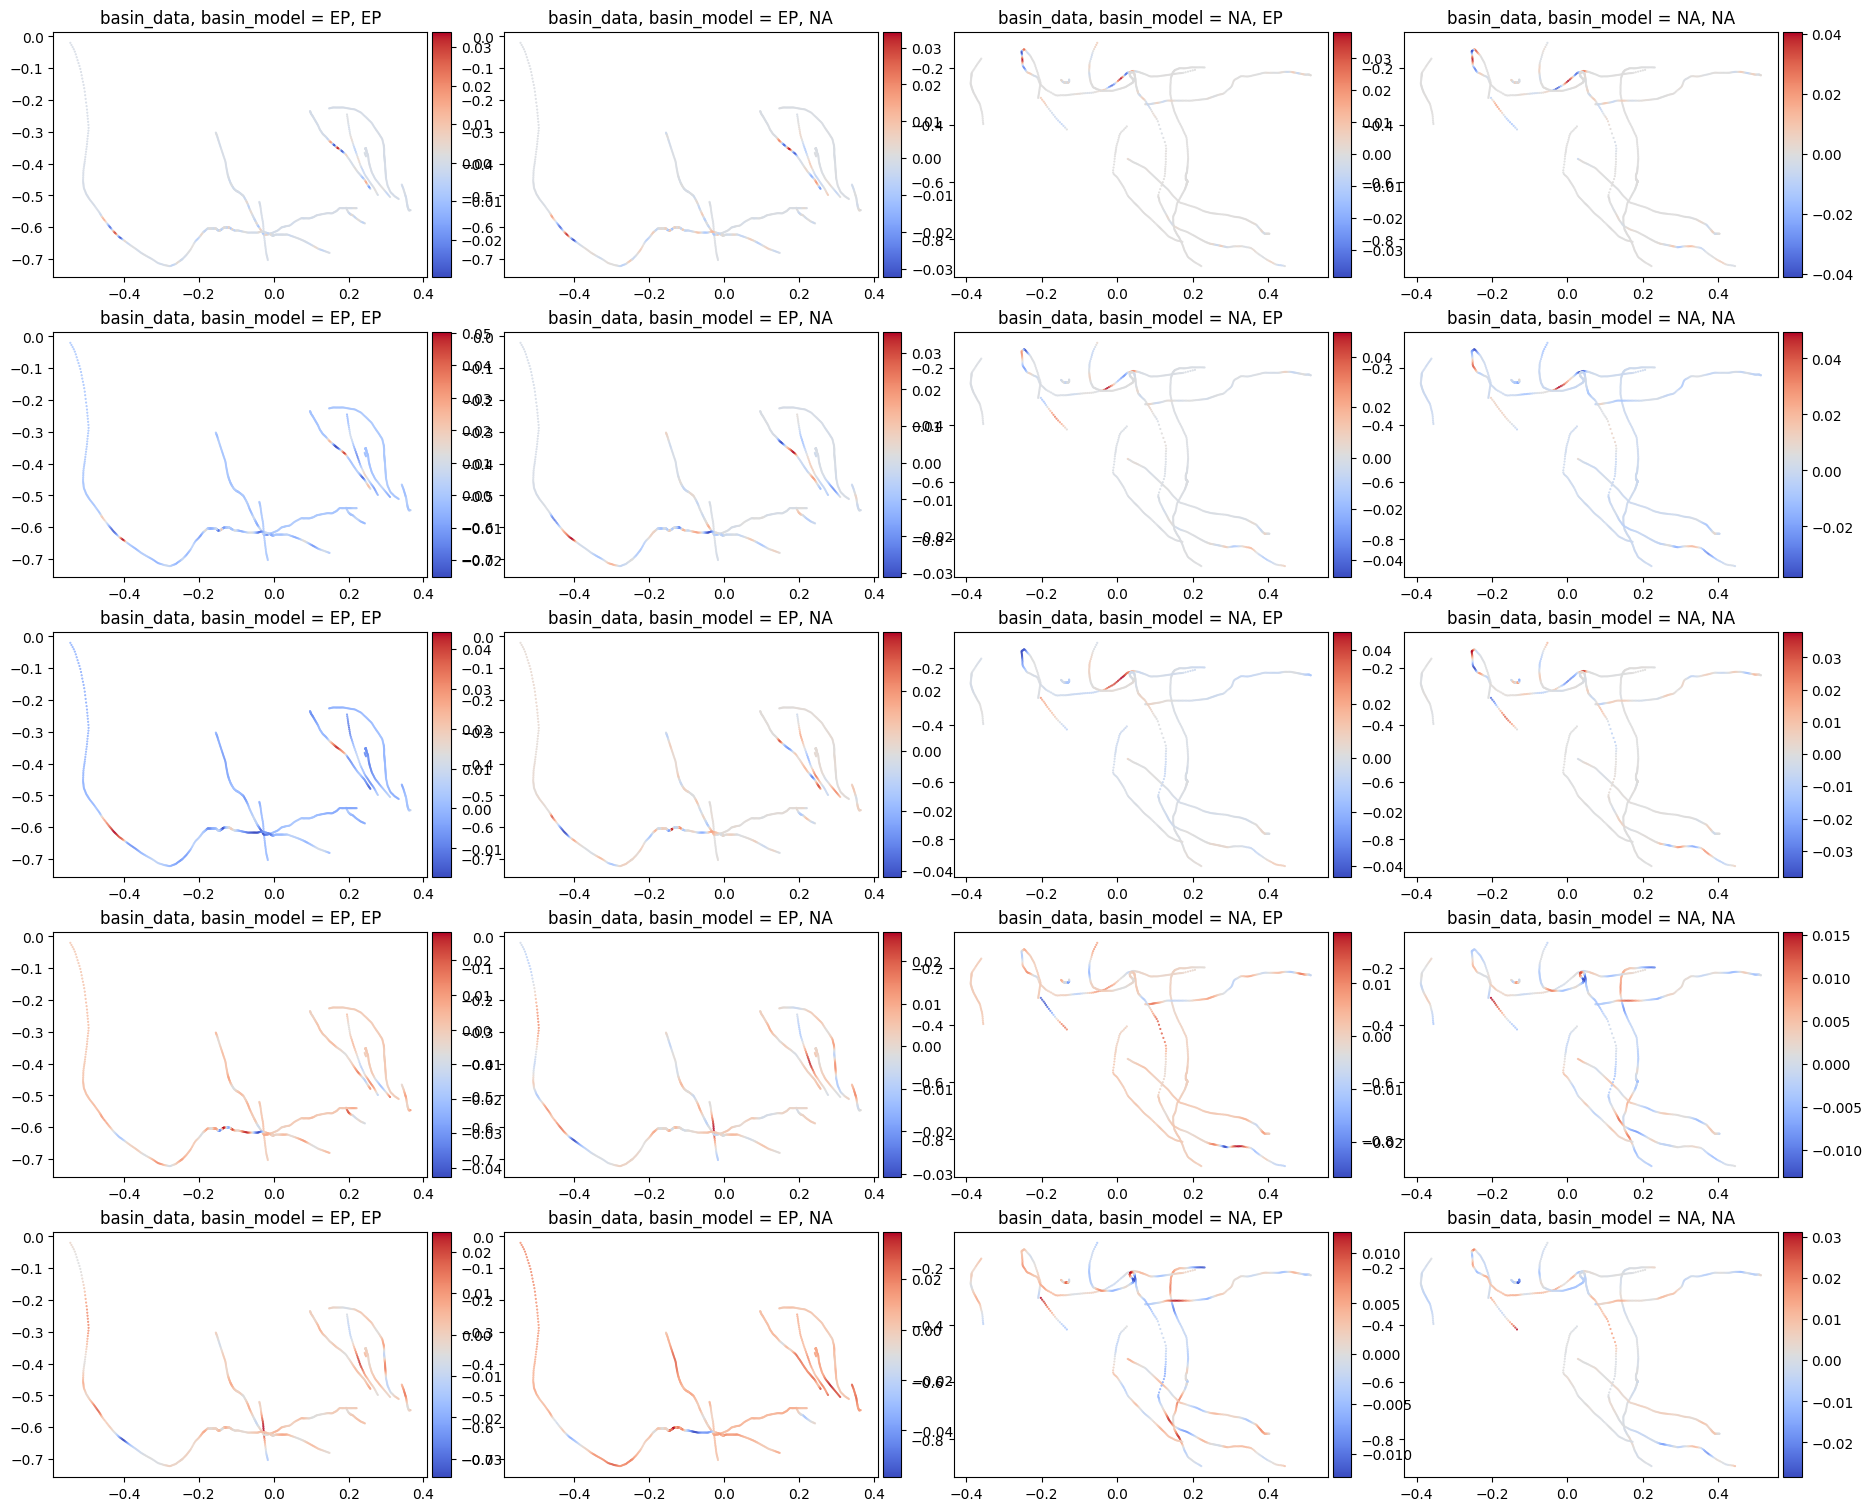

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(len(evec_idx), 4, constrained_layout=True)
fig.set_size_inches(18, 15)

idx = -1
cmap = plt.cm.coolwarm


for i, e_idx in enumerate(evec_idx):
    for j, (basin_data, basin_model) in enumerate(product(basins, repeat=2)):
        im = ax[i, j].scatter(contexts_sample[basin_data]["test"].data[:idx, 0, 0], contexts_sample[basin_data]["test"].data[:idx, 0, 1], marker=".", cmap=cmap, c = evecs_right[(basin_data, basin_model)][:idx, e_idx], s = 1)
        divider = make_axes_locatable(ax[i, j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax[i, j].set_title(f"basin_data, basin_model = {basin_data}, {basin_model}")
    
    # im = ax[i].scatter(test_dataset.data[:idx, 0, 0], test_dataset.data[:idx, 0, 1], marker=".", cmap=cmap, c = evec_right_k[:idx, e_idx], s = 1)
    # divider = make_axes_locatable(ax[i])
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(im, cax=cax, orientation='vertical')
    # ax[i].set_title(f"Eigenvalue = {evals_k[e_idx]}")

In [ ]:
# context_length_test_data = 42
context_length_test_data = 120

In [ ]:
benchmark = ModelBenchmark(
    feature_list,
    tc_tracks_train,
    tc_tracks_test,
    basin=basin,
    # basin="NA",
    scaler=scaler,
    context_length=context_length_test_data,
    # context_length=flag_params["context_length"],
)

benchmark._standardize_data()

contexts = {
    "train": benchmark.tensor_context_train,
    "test": benchmark.tensor_context_test,
}

Data entry 0 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 5 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 7 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 8 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 11 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 12 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 14 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 17 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 19 has been removed since it is shorter than the 

Select a random collection of time series in the test context and predict `n_steps = 10` steps into the future.

In [ ]:
test_dataset = contexts["train"]

In [ ]:
test_dataset.context_length

120

In [ ]:
model.rank

50

In [ ]:
model.reduced_rank

False

In [ ]:
model.lookback_len

41

In [ ]:
evals, evec_right = model.eig(eval_right_on=test_dataset)

In [ ]:
test_dataset.shape

(38768, 120, 7)

In [ ]:
evec_right.shape

(38768, 50)

In [ ]:
# evals_k = evals
# evec_right_k = evec_right

indices_k, evals_k = get_top_k_ev_and_indices_below_zero(evals, top_k)
print(evals_k)

# top_evals = topk(np.abs(evals), top_k)
# indices_k = top_evals.indices
# evals_k = evals[indices_k]
# print(evals_k)

evec_right_k = evec_right[:, indices_k]

[0.99961904+0.02562718j 0.99961904-0.02562718j 0.99921238+0.0278865j
 0.99921238-0.0278865j  0.9988293 +0.00568862j 0.9988293 -0.00568862j
 0.99833444+0.02113671j 0.99833444-0.02113671j 0.99820149+0.00135209j
 0.99820149-0.00135209j]


In [ ]:
evec_idx = list(range(top_k))
# evec_idx = list(range(0, 50, 4))

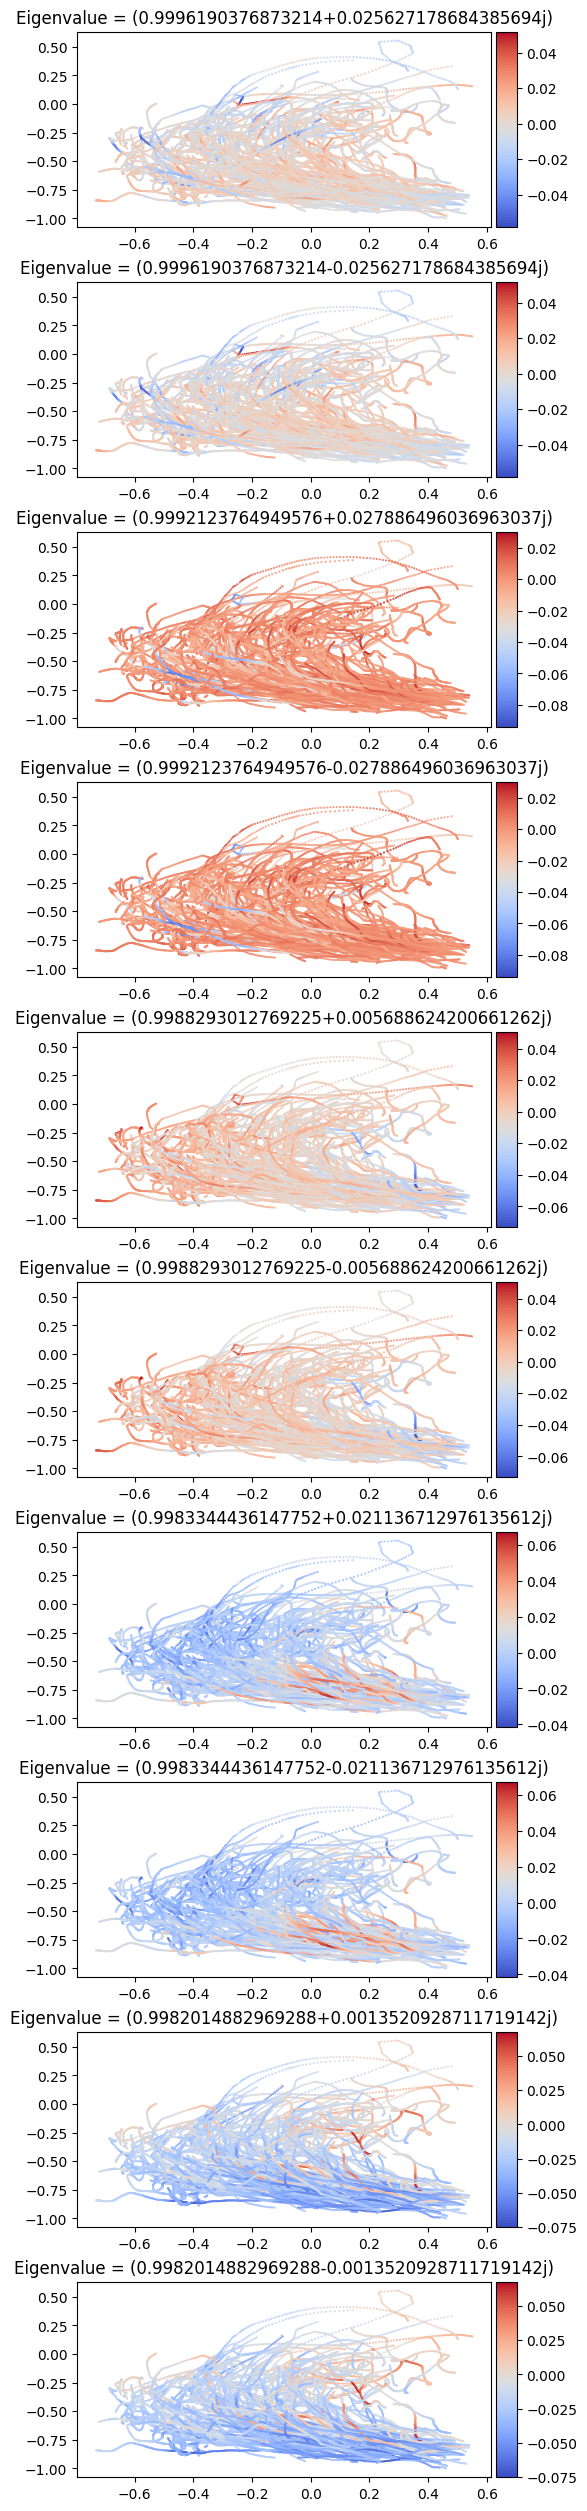

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(len(evec_idx), 1, constrained_layout=True)
fig.set_size_inches(5, 25)

idx = -1
cmap = plt.cm.coolwarm

for i, e_idx in enumerate(evec_idx):
    im = ax[i].scatter(test_dataset.data[:idx, 0, 0], test_dataset.data[:idx, 0, 1], marker=".", cmap=cmap, c = evec_right_k[:idx, e_idx], s = 1)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i].set_title(f"Eigenvalue = {evals_k[e_idx]}")


## Eigenfunction clustering

In the following we investigate the dynamical signatures of the different cyclone basins on the level of the Koopman eigenfunctions. For this we project the cyclone tracks onto the first `top_k` Koopman eigenfunctions of each basin. This results in a relatively low-dimensional dataset (compared to the dimensionality of the full cyclone tracks) which we visualize via nonlinear dimensionality reduction. For this we use the UMAP algorithm.

The training of the UMAP model is done in `train_models/koopman_spectral_analysis/koopman_spectral_data_eigenfunction_clustering.py`.

In [4]:
"""Trains UMAP model for eigenfunction clustering."""

import os
import pickle
import pandas as pd
from random import sample
import numpy as np
from itertools import product

import umap
from sklearn.model_selection import train_test_split

from klearn_tcyclone.climada.tc_tracks_tools import BASINS_SELECTION
from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.data_utils import (
    load_model,
    standardized_context_dataset_from_TCTracks,
)
from klearn_tcyclone.kooplearn.spectral_analysis import (
    get_df_evecs,
)
from klearn_tcyclone.training_utils.training_utils import (
    extend_by_default_flag_values,
)

First we set all the parameters as in `train_models/koopman_spectral_analysis/koopman_spectral_data_eigenfunction_clustering.py`.

In [45]:
current_file_dir_path = os.getcwd()
path_training_results = os.path.join(
    current_file_dir_path,
    "../train_models/",
    "training_results",
)

model_str = "Nystroem_RRR"



time_lag = 1
slide_by = 1
basins = BASINS_SELECTION
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    "radius_max_wind",
    "radius_oci",
    "central_pressure",
    "environmental_pressure",
]


flag_params = {
    "koopman_kernel_num_train_stops": 10,
    "year_range": [1980, 2021],
    "model": model_str,
    "koopman_kernel_length_scale": 10.0,
    "koopman_kernel_rank": 50,
    "koopman_kernel_num_centers": 800,
    "context_length": 32,
    "koopman_kernel_reduced_rank": False,
    "time_step_h": 1.0,
}
flag_params = extend_by_default_flag_values(flag_params)

model_config = {
    "length_scale": 10.0,
    "reduced_rank": False,
    "rank": 50,
    "num_centers": 600,
    "tikhonov_reg": 1e-8,
    "svd_solver": "arnoldi",
    "rng_seed": 42,
}


Second we import the tropical cyclone data, which we want to visualize in the (reduced) eigenfunction space. We include the tropical cyclone data for the five most important basins EP, NA, SI, SP, WP.

(Data loading takes around 6 mins)

In [6]:
# Datasets
tc_tracks_dict = get_TCTrack_dict(
    basins=basins,
    time_step_h=flag_params["time_step_h"],
    year_range=flag_params["year_range"],
)

for basin in basins:
    tc_tracks_train, tc_tracks_test = train_test_split(
        tc_tracks_dict[basin].data, test_size=0.1, random_state=flag_params["seed"]
    )
    tc_tracks_dict[basin] = {
        "train": tc_tracks_train,
        "test": tc_tracks_test,
    }

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2025-01-01 19:02:58,616 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-01-01 19:04:04,304 - climada.hazard.tc_tracks - WARNING - 232 storm events are discarded because no valid wind/pressure values have been found: 1980094N06181, 1980161N09249, 1980169N12250, 1980177N13259, 1980183N13250, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:
d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:1511: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_one_interp_data" failed type inference due to: non-precise type pyobject
During: typing of argument at d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py (1545)

File "..\.venv\Lib\site-packages\climada\hazard\tc_tracks.py", line 1545:
    def _one_interp_data(track, time_step_h, land_geom=None):
       

2025-01-01 19:04:27,226 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-01-01 19:05:10,590 - climada.hazard.tc_tracks - WARNING - 57 storm events are discarded because no valid wind/pressure values have been found: 1980199N31284, 1980200N25270, 1980204N23287, 1980226N15339, 1980238N16328, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


2025-01-01 19:05:30,324 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-01-01 19:06:24,635 - climada.hazard.tc_tracks - WARNING - 134 storm events are discarded because no valid wind/pressure values have been found: 1980015S18060, 1980032S14071, 1980056S15059, 1980068S13068, 1980075S11072, ...
2025-01-01 19:06:24,643 - climada.hazard.tc_tracks - WARNING - 9 storm events are discarded because only one valid timestep has been found: 1980002S15081, 1980005S11059, 1980009S14066, 1980010S20043, 1980010S22048, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


2025-01-01 19:06:49,126 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-01-01 19:07:23,536 - climada.hazard.tc_tracks - WARNING - 71 storm events are discarded because no valid wind/pressure values have been found: 1980085S11135, 1981022S13155, 1983027S21224, 1983082S15216, 1983347S16154, ...
2025-01-01 19:07:23,543 - climada.hazard.tc_tracks - WARNING - 1 storm events are discarded because only one valid timestep has been found: 1992358S07161.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


2025-01-01 19:07:38,057 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-01-01 19:09:06,869 - climada.hazard.tc_tracks - WARNING - 360 storm events are discarded because no valid wind/pressure values have been found: 1980076N06148, 1980087N13117, 1980181N10130, 1980197N15133, 1980225N11145, ...
2025-01-01 19:09:06,885 - climada.hazard.tc_tracks - WARNING - 2 storm events are discarded because only one valid timestep has been found: 1996318N33146, 2004327N16125.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


In [46]:
tc_tracks_dict.keys()

dict_keys(['EP', 'NA', 'SI', 'SP', 'WP'])

The results are plotted below. We choose a specific parameter combination as example. Other choices, for example for the UMAP hyperparameters or for the context window size, can be considered.

In [47]:
# umap_n_neighbors = 600
# umap_min_dist = 0.1
# training_data_size = 30
top_k = 10

training_data_size = 70
umap_n_neighbors = 600
umap_min_dist = 0.2

Pre-process data and compute Koopman eigenfunctions for each basin.

In [48]:
tc_tracks_dict_sample = {}
for basin in basins:
    tc_tracks_dict_sample[basin] = {
        "train": sample(tc_tracks_dict[basin]["train"], k=training_data_size),
        # "test": sample(tc_tracks_dict[basin]["test"], k=training_data_size),
    }


models = {}
scalers = {}
for basin in basins:
    flag_params["basin"] = basin
    best_model_dict, _ = load_model(flag_params, path_training_results)
    models[basin] = best_model_dict["model"]
    scalers[basin] = best_model_dict["scaler"]


contexts_sample = {}
for basin in basins:
    tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
        tc_tracks_dict_sample[basin]["train"],
        feature_list=feature_list,
        scaler=scalers[basin],
        context_length=flag_params["context_length"],
        time_lag=time_lag,
        fit=False,
        periodic_shift=True,
        basin=basin,
    )
    # tensor_context_test_standardized = standardized_context_dataset_from_TCTracks(
    #     tc_tracks_dict_sample[basin]["test"],
    #     feature_list=feature_list,
    #     scaler=scalers[basin],
    #     context_length=flag_params["context_length"],
    #     time_lag=time_lag,
    #     fit=False,
    #     periodic_shift=True,
    #     basin=basin,
    # )

    contexts_sample[basin] = {
        "train": tensor_context_train_standardized,
        # "test": tensor_context_test_standardized,
    }


df_evecs = get_df_evecs(
    {key: val["train"] for key, val in contexts_sample.items()},
    models=models,
    basins=basins,
    top_k=top_k,
)

D:\work\projects\repositories\koopman_learning_tropical_cyclone\klearn_tcyclone\data_utils.py:643: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_dict = torch.load

Data entry 9 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 43 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 60 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 1 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 17 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 13 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 23 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 12 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 27 has been removed since it is shorter than the 
     

Load the pre-trained UMAP model and embedd the eigenfunction coordinates into UMAP feature space.

UMAP transform (not training) takes around 3 minutes.

In [49]:
if model_config["reduced_rank"]:
    reduced_rank_str = "redrank"
else:
    reduced_rank_str = ""

    
file_name = "_".join(
    [
        f"cl{flag_params['context_length']}",
        f"tsteph{flag_params['time_step_h']}",
        f"nc{model_config['num_centers']}",
        f"tkreg{model_config['tikhonov_reg']}",
        reduced_rank_str,
        f"um_nneigh{umap_n_neighbors}",
        f"um_md{umap_min_dist}",
    ]
)

folder_name = "_".join(
    [
        "year_range",
        *map(str, flag_params["year_range"]),
        f"train_dsize{training_data_size}",
        f"topk{top_k}",
    ]
)

load_path = os.path.join(
    "../data/",
    "koopman_spectral_analysis/",
    "eigenfunction_clustering/",
    folder_name,
)

os.makedirs(load_path, exist_ok=True)

print("Load UMAP model.")
with open(os.path.join(load_path, "umap_" + file_name + ".pickle"), "rb") as file:
    umap_model = pickle.load(file)


data = df_evecs.drop(columns=["basin_data"])
embedding = umap_model.transform(data.to_numpy())
embedding = pd.DataFrame(embedding, columns=["x", "y"])
embedding["basin_data"] = list(df_evecs["basin_data"])

Load UMAP model.


Visualize the embedded data in two-dimensional feature space.

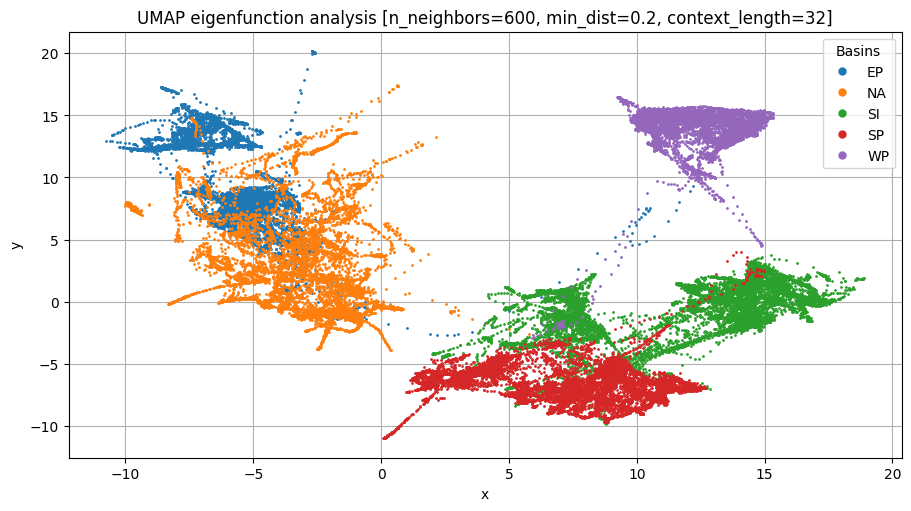

In [51]:
fig, ax = plt.subplots(1, 1, constrained_layout=True)
fig.set_size_inches(9,5)

for basin_data in basins:
    ax.plot(embedding[embedding["basin_data"] == basin_data]["x"], embedding[embedding["basin_data"] == basin_data]["y"], marker="o", linestyle="", label=basin_data, markersize=1)


ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"UMAP eigenfunction analysis [n_neighbors={umap_n_neighbors}, min_dist={umap_min_dist}, context_length={flag_params['context_length']}]")
ax.grid()
lgnd = ax.legend(title="Basins", markerscale=5.)

save_path = os.path.join(
    "../plots/", "koopman_spectral_analysis/", "eigenfunction_clustering/", folder_name
)
os.makedirs(save_path, exist_ok=True)
fig.savefig(os.path.join(save_path, "umap_clustering_" + file_name + ".png"), bbox_inches='tight')